In [2]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import pickle
from datetime import datetime
from pathlib import Path
from scipy.signal import savgol_filter
from scipy.stats import zscore, median_abs_deviation
import pyarrow.parquet as pq 

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):   # cells can be skipped by using '%%skip' in the first line
    return

In [3]:
# ------------ LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  --------------
import sys, os; from pathlib import Path                                                #|
global ROOT, DATA_PATH, IS_NOTEBOOK; IS_NOTEBOOK = True                                 #|
ROOT = Path('.').resolve() if IS_NOTEBOOK else Path('.').resolve()                      #|
sys.path.append(os.path.abspath(ROOT))                                                  #|
from data import get_data_path  # paths set in "data/__init__.py"                       #|
DATA_PATH = get_data_path()                                                             #|
print(f"{'-'*60}\n{DATA_PATH}:\t{', '.join([_.name for _ in DATA_PATH.glob('*/')])}") #|
print(f"{ROOT}:\t{', '.join([_.name for _ in ROOT.glob('*/')])}")   	                #|
# ----------------------------------------------------------------------------------------

------------------------------------------------------------
/home/sieglew/MA-Data:	processed_resampled, TripFiles, __pycache__, processed_2, trips_processed_resampled, y_true, processed, trips_processed_pickles, processed_new, trips_processed_final
/home/sieglew/MA-eR-PINN:	project, ref, test, data, src, .git, archive


In [4]:
# relative Imports: ---------------------------------------------------------------------------------------------------
from src.physics_model.VehModel import CreateVehicle

# FILE SOURCES ---------------------------------------------------------------
parquet_folder = Path(DATA_PATH, "processed") # Trip parquet files

# OUTPUT LOCATIONS ---------------------------------------------------------------
trips_processed_final = Path(DATA_PATH, "trips_processed_final") # Trip parquet files
trips_processed_resampled = Path(DATA_PATH, "trips_processed_resampled") # Trip parquet filesn for resampled time series
trips_processed_pickles = Path(DATA_PATH, "trips_processed_pickles") # Trip parquet files

In [5]:
# GET DIRECTORY CONTENS:
def get_files(folder, ext, full = False):
    return [os.fspath(_) if full else os.path.basename(_) for _ in folder.iterdir() if str(_).endswith(ext)]

trips = get_files(parquet_folder, ".parquet")

In [6]:
# get list of signals
df = pd.read_parquet(Path(parquet_folder, trips[0]), engine='fastparquet')
all_columns = df.columns
assert len(all_columns) == 114

In [7]:
# first scan of trips to identify sparse signals and trips that do not meet the requirements
def first_scan(trips, all_columns):
    sparse_signals = set(all_columns)  # Start with all columns
    short_trips = []               # collect all trips shorter than limit of 1 km

    for n,f  in enumerate(trips):
        df = pd.read_parquet(Path(parquet_folder, f), engine='fastparquet')

        #current_sparse = set(df.columns[df.isna().mean() > 0.8])
        #sparse_signals &= current_sparse  # Keep only columns that are sparse in all dataframes

        dist = df["hirestotalvehdist_cval_icuc"]
        d_dist = dist.iloc[dist.last_valid_index()] - dist.iloc[dist.first_valid_index()]
        if d_dist < 1: 
            print(f"less than 1 km: {f}, {n}")
            short_trips.append(f)

    return sparse_signals, short_trips


In [19]:
# SUMMARY OF ANALYSIS: 
#############################################################################################################################################

# these signals always have more than 80% nans and will be removed from all trips:
sparse_signals = {'chrgcoupproxydet_stat','hv_batmaxdischrgpwrlim_cval','inv1_curr_cval_api1','inv1_pwr_cval_api1', 
    'inv1_pwr_cval_api3','inv1_spd_cval_api1','inv2_curr_cval_api2','inv2_pwr_cval_api2', 
    'inv2_spd_cval_api2','odometer','signal_date','vehicle_id', 'diff'}

# these signals are all-nans in more than 140 trips and will be removed from all trips:
collected_signals = ['brc_stat_brc2', 'maxpwr_contendrnbrkresist2', 'dsrdpwr_contendrn2_cval', 'maproadgrad_cval',
    'dsrdpwr_contendrn_cval', 'brc_stat_brc1', 'meanmoduletemperature_bms01', 'linkvoltage_bms05', 'hv_dclink_volt_cval_brc2',
    'oiltemp_ra_cval', 'hv_ptc2_pwr_cval', 'currpwr_contendrnbrkresist2', 'epto_pwr_cval', 'currtmp_brkresist1int_cval', 
    'hv_dclink_volt_cval_brc', 'currpwr_contendrnbrkresist_cval', 'maxpwr_contendrnbrkresist_cval', 'currtmp_brkresist2int_cval', 'hv_bat_dc_volt_cval_bms1']

# these trips are shorter than 1 km and will be removed from the dataset:
short_trips = ['v_id983V101_trip146.parquet', 'v_id983V101_trip30.parquet', 'v_id983V101_trip70.parquet', 'v_id983V101_trip8.parquet', 'v_id983V101_trip94_2.parquet', 
    'v_id983V10_trip19.parquet', 'v_id983V10_trip20.parquet', 'v_id983V10_trip22.parquet', 'v_id983V10_trip31.parquet', 'v_id983V4_trip72.parquet', 
    'v_id983V10_trip32.parquet', 'v_id983V10_trip36.parquet', 'v_id983V13_trip199.parquet', 'v_id983V14_trip283.parquet', 'v_id983V14_trip9.parquet', 
    'v_id983V15_trip70.parquet', 'v_id983V16_trip1.parquet', 'v_id983V16_trip2.parquet', 'v_id983V16_trip42.parquet', 'v_id983V17_trip132.parquet', 
    'v_id983V17_trip142.parquet', 'v_id983V17_trip198.parquet', 'v_id983V17_trip199.parquet', 'v_id983V17_trip242.parquet', 'v_id983V18_trip2.parquet', 
    'v_id983V18_trip6.parquet', 'v_id983V19_trip103.parquet', 'v_id983V19_trip111.parquet', 'v_id983V19_trip113.parquet', 'v_id983V19_trip49.parquet', 
    'v_id983V19_trip87.parquet', 'v_id983V19_trip99.parquet', 'v_id983V1_trip100.parquet', 'v_id983V1_trip109.parquet', 'v_id983V1_trip116.parquet', 
    'v_id983V1_trip117.parquet', 'v_id983V1_trip118.parquet', 'v_id983V1_trip129.parquet', 'v_id983V1_trip13.parquet', 'v_id983V1_trip132.parquet', 
    'v_id983V1_trip142.parquet', 'v_id983V1_trip162.parquet', 'v_id983V1_trip163.parquet', 'v_id983V1_trip17.parquet', 'v_id983V1_trip24.parquet', 
    'v_id983V1_trip26.parquet', 'v_id983V1_trip29.parquet', 'v_id983V1_trip31.parquet', 'v_id983V1_trip40.parquet', 'v_id983V1_trip41.parquet', 
    'v_id983V1_trip43.parquet', 'v_id983V1_trip44.parquet', 'v_id983V1_trip46.parquet', 'v_id983V1_trip54.parquet', 'v_id983V1_trip57.parquet', 
    'v_id983V1_trip6.parquet', 'v_id983V2_trip60.parquet', 'v_id983V4_trip139.parquet', 'v_id983V4_trip36.parquet', 'v_id983V4_trip58.parquet']

# these trips might be removed in order to make sure that all remaining signals are never all-nans
# this ensures that the preprocessed final dataset has no all-nan signals and and the remaining nans can be removed by
# the ffill and bfill methods in the preprocess filter. The resulting dataset will have no nans while including the majority of trips and signals. 
remove_selection = ['v_id983V2_trip5.parquet', 'v_id983V10_trip60.parquet', 'v_id983V2_trip19.parquet', 'v_id983V13_trip2.parquet', 
'v_id983V13_trip276_2.parquet', 'v_id983V14_trip2.parquet', 'v_id983V16_trip185.parquet', 'v_id983V11_trip15.parquet', 
'v_id983V10_trip27.parquet', 'v_id983V10_trip48.parquet', 'v_id983V1_trip8.parquet', 'v_id983V10_trip21.parquet', 'v_id983V16_trip304.parquet', 
'v_id983V2_trip37.parquet', 'v_id983V1_trip16.parquet', 'v_id983V1_trip16_2.parquet', 'v_id983V10_trip57.parquet', 'v_id983V16_trip190.parquet',
'v_id983V10_trip29_2.parquet', 'v_id983V16_trip197_2.parquet', 'v_id983V10_trip39.parquet', 'v_id983V10_trip49.parquet', 'v_id983V101_trip54.parquet', 
'v_id983V1_trip2_2.parquet', 'v_id983V10_trip4.parquet', 'v_id983V17_trip46.parquet', 'v_id983V101_trip175.parquet', 'v_id983V10_trip39_2.parquet',
'v_id983V11_trip16.parquet', 'v_id983V2_trip44.parquet', 'v_id983V10_trip61.parquet', 'v_id983V10_trip54.parquet', 'v_id983V16_trip188_2.parquet',
'v_id983V10_trip35.parquet', 'v_id983V10_trip16.parquet', 'v_id983V17_trip69.parquet', 'v_id983V17_trip1.parquet', 'v_id983V10_trip38.parquet', 
'v_id983V1_trip1.parquet', 'v_id983V10_trip52_2.parquet', 'v_id983V1_trip7.parquet', 'v_id983V10_trip23.parquet', 'v_id983V11_trip16_2.parquet',
'v_id983V16_trip184.parquet', 'v_id983V2_trip21.parquet', 'v_id983V2_trip15.parquet', 'v_id983V10_trip47.parquet', 'v_id983V2_trip12.parquet', 
'v_id983V2_trip3_2.parquet', 'v_id983V16_trip180.parquet', 'v_id983V2_trip25.parquet', 'v_id983V2_trip7.parquet', 'v_id983V16_trip179.parquet',
'v_id983V2_trip27.parquet', 'v_id983V2_trip13.parquet', 'v_id983V2_trip3.parquet', 'v_id983V17_trip70.parquet', 'v_id983V11_trip13_2.parquet',
'v_id983V1_trip9_2.parquet', 'v_id983V10_trip26_2.parquet', 'v_id983V10_trip24.parquet', 'v_id983V10_trip29.parquet', 'v_id983V2_trip17.parquet',
'v_id983V10_trip55.parquet', 'v_id983V10_trip14.parquet', 'v_id983V16_trip178.parquet', 'v_id983V10_trip58.parquet', 'v_id983V2_trip39.parquet',
'v_id983V16_trip183.parquet', 'v_id983V10_trip37.parquet', 'v_id983V10_trip5.parquet', 'v_id983V10_trip20_2.parquet', 'v_id983V2_trip32.parquet',
'v_id983V16_trip188.parquet', 'v_id983V2_trip36.parquet', 'v_id983V10_trip25.parquet', 'v_id983V2_trip30.parquet', 'v_id983V11_trip14_2.parquet',
'v_id983V2_trip20.parquet', 'v_id983V2_trip38.parquet', 'v_id983V16_trip184_2.parquet', 'v_id983V1_trip11.parquet', 'v_id983V10_trip55_2.parquet',
'v_id983V10_trip5_2.parquet', 'v_id983V10_trip37_2.parquet', 'v_id983V2_trip39_2.parquet', 'v_id983V10_trip3.parquet',
'v_id983V10_trip60_2.parquet', 'v_id983V10_trip2.parquet', 'v_id983V2_trip16.parquet', 'v_id983V2_trip24.parquet', 'v_id983V2_trip18.parquet', 
'v_id983V10_trip59.parquet', 'v_id983V16_trip182.parquet', 'v_id983V1_trip6_2.parquet', 'v_id983V10_trip42.parquet', 'v_id983V2_trip44_2.parquet',
'v_id983V10_trip18.parquet', 'v_id983V17_trip2.parquet', 'v_id983V16_trip3.parquet', 'v_id983V2_trip36_2.parquet', 'v_id983V10_trip10.parquet', 
'v_id983V16_trip192.parquet', 'v_id983V2_trip35.parquet', 'v_id983V13_trip5.parquet', 'v_id983V2_trip10.parquet', 'v_id983V1_trip9.parquet', 
'v_id983V10_trip6.parquet', 'v_id983V10_trip44.parquet', 'v_id983V19_trip2_2.parquet', 'v_id983V16_trip186.parquet', 'v_id983V10_trip15.parquet',
'v_id983V19_trip4.parquet', 'v_id983V11_trip13.parquet', 'v_id983V16_trip196.parquet', 'v_id983V2_trip33.parquet', 'v_id983V16_trip191.parquet',
'v_id983V1_trip2.parquet', 'v_id983V10_trip41.parquet', 'v_id983V16_trip193.parquet', 'v_id983V2_trip11.parquet', 'v_id983V17_trip5.parquet',
'v_id983V10_trip17.parquet', 'v_id983V1_trip15.parquet', 'v_id983V10_trip9.parquet', 'v_id983V2_trip4.parquet', 'v_id983V10_trip42_2.parquet',
'v_id983V10_trip52.parquet', 'v_id983V4_trip86.parquet', 'v_id983V10_trip40.parquet', 'v_id983V10_trip28.parquet',
'v_id983V10_trip14_2.parquet', 'v_id983V2_trip23.parquet', 'v_id983V16_trip181.parquet', 'v_id983V1_trip4.parquet', 
'v_id983V10_trip7.parquet', 'v_id983V1_trip34.parquet', 'v_id983V19_trip1.parquet', 'v_id983V2_trip34.parquet', 'v_id983V10_trip43.parquet',
'v_id983V16_trip187.parquet', 'v_id983V17_trip4.parquet', 'v_id983V13_trip276.parquet', 'v_id983V10_trip26.parquet', 
'v_id983V16_trip180_2.parquet', 'v_id983V16_trip195.parquet', 'v_id983V11_trip14.parquet', 'v_id983V16_trip197.parquet',
'v_id983V13_trip1.parquet', 'v_id983V1_trip12.parquet', 'v_id983V10_trip56.parquet', 'v_id983V10_trip59_2.parquet',
'v_id983V2_trip8.parquet', 'v_id983V2_trip1.parquet', 'v_id983V2_trip22_2.parquet', 'v_id983V1_trip10.parquet', 'v_id983V2_trip42.parquet', 
'v_id983V2_trip15_2.parquet', 'v_id983V10_trip57_2.parquet', 'v_id983V10_trip49_2.parquet', 'v_id983V10_trip8.parquet',
'v_id983V10_trip50.parquet', 'v_id983V4_trip79.parquet', 'v_id983V16_trip194.parquet', 'v_id983V2_trip2.parquet',
'v_id983V10_trip13_2.parquet', 'v_id983V13_trip4.parquet', 'v_id983V17_trip6.parquet', 'v_id983V2_trip24_2.parquet', 
'v_id983V2_trip9.parquet', 'v_id983V16_trip185_2.parquet', 'v_id983V10_trip13.parquet', 'v_id983V2_trip14.parquet', 
'v_id983V2_trip22.parquet', 'v_id983V19_trip2.parquet', 'v_id983V2_trip6.parquet','v_id983V13_trip252.parquet',
'v_id983V4_trip29.parquet','v_id983V1_trip180_2.parquet','v_id983V19_trip92.parquet','v_id983V17_trip14_2.parquet','v_id983V101_trip51_2.parquet',
'v_id983V1_trip55.parquet','v_id983V101_trip24.parquet','v_id983V12_trip107_2.parquet','v_id983V19_trip23.parquet']

# conlusively, these are the trips to be included in the final dataset:
trips = [_ for _ in trips if _ not in short_trips and _ not in remove_selection]
print('Keep no. trips: ', len(trips))
# these are the signals that will be removed
drop_signals = list(sparse_signals.union(collected_signals))
print('Keep no. signals: ', len(all_columns) - len(drop_signals))

Keep no. trips:  2951
Keep no. signals:  82


In [9]:
# these signals should be explicitly considered for outlier removal to clean and improve data quality
signal_remove_outliers = ["latitude_cval_ippc", "longitude_cval_ippc","altitude_cval_ippc","roadgrad_cval_pt", "bs_roadincln_cval","hirestotalvehdist_cval_icuc","hirestotalvehdist_cval_cpc","vehspd_cval_cpc", "hv_batmomavldischrgen_cval_1", "hv_batmomavlchrgen_cval_bms1",
"hv_bat_soc_cval_bms1", "airtempinsd_cval_hvac", "airtempoutsd_cval_cpc", "airtempoutsd_cval_sca", "ambtemp_cval_pt", "hv_batavcelltemp_cval_bms1","hv_bathighcelltemp_cval_bms1","hv_batlowcelltemp_cval_bms1"]

In [11]:
def expand_indices(r_list, ws, offset, max_val):
    r_set = set(r_list).copy()
    for i in range(-ws,ws+1):
        r_set = r_set | set([x+i for x in r_list])
    r_set = [x+offset for x in list(r_set)]
    drops = [x for x in list(r_set) if (x>=0 and x<max_val)]
    return sorted(drops)
    
def smooth_filter(X, ws, remove_outliers = True, smooth = True):

    def custom_filter(X,ws, remove_outliers, thresh = 8):
        X_filtered = X.copy()
        X_noise  = abs(zscore(X.ffill().bfill() - savgol_filter(X.ffill().bfill(), ws,1, mode='nearest'), nan_policy='omit'))
        if remove_outliers:
            cr = X.std() - median_abs_deviation(X, nan_policy='omit')
            thresh_new = max(abs(X.std() / cr), thresh) if cr != 0 else max(abs(X.std()), thresh)
            peaks = expand_indices(list(np.where((X_noise > thresh_new))[0]), int(ws), 0, len(X))
            X_filtered[peaks] = np.nan
            X_filtered[X_noise.isna()] = np.nan
        else:
            thresh_new = None

        if X_filtered.nunique() < 2:
            X_filtered.fillna(X_filtered.mean(), inplace=True)
        else:
            X_filtered.ffill(inplace=True)
            X_filtered.bfill(inplace=True)  

        return X_filtered, X_noise, thresh_new

    X_filtered, X_noise, thresh = custom_filter(X, ws, remove_outliers = remove_outliers)
    
    if (X - X_filtered).std() > 10:
        X_filtered, X_noise, thresh = custom_filter(X_filtered, ws, remove_outliers = remove_outliers)

    if smooth: X_filtered = savgol_filter(X_filtered, ws/2,1, mode='nearest')
    return X_filtered, X_noise, thresh

In [11]:
# PREPROCESSING #########################################################
#########################################################################
# loop through every file:
for n, f in enumerate(trips):
    print(f"Reading File: {f}, {n}/{len(trips)}")
    # get file info
    vehicle_id = f[8:10].strip("_t")
    file_code = f[7:-8]
    prefix = f[:7]
    # read to dataframe
    df = pd.read_parquet(Path(parquet_folder, f), engine='fastparquet')
    df.sort_index(axis=1, inplace=True)
    # drop sparse signals
    df.drop(columns = drop_signals, inplace=True)

    # correct timestamp if necessary:
    if max(df.signal_time).year < 2000:
        df.signal_time = pd.to_datetime(df.signal_ts * (10**3))

    signal_only_nans = list(df.columns[np.array(df.isnull().all())])
    if signal_only_nans: print(f"Signals with all NaNs: {signal_only_nans}")
    signal_with_nans = list(df.columns[np.array(df.isnull().any())])
    constants = {}

    for sig in df.columns:
        # extract constant values:
        if len({x for x in df[sig] if x==x}) == 1:      # number of distinct non-NaN-values
            constants[sig] = df[sig].iloc[df[sig].first_valid_index()] 

        # Filtering, smoothing and outlier removal:
        if sig in signal_remove_outliers:
            df[sig], _, _ = smooth_filter(df[sig], 60, remove_outliers = True, smooth = False)
        elif sig in signal_with_nans and df[sig].nunique() > 1:    
            df[sig], _, _ = smooth_filter(df[sig], 60, remove_outliers = False, smooth = False)
        else:
            df[sig] = df[sig].fillna(df[sig].mean())

    # check again for nans and fill only columns with nans:
    columns_with_nans = df.columns[df.isna().any()].tolist()
    if columns_with_nans:
        df[columns_with_nans] = df[columns_with_nans].ffill().bfill()
    
    # check if there are still any nans:
    if df.isna().any().any():
        print(f"Warning: There are still NaN values in the dataframe for file {f}, columns_with_nans: {columns_with_nans}")

    df.to_parquet(f'{trips_processed_final}/{prefix + file_code}.parquet')

    # RESAMPLING: --> separate directory
    ###############################################
    df_resampled = df.resample('10s', on = 'signal_time').mean() # RESAMPLE AT 10 seconds intervals
    df_resampled.reset_index(inplace=True)

    # as the resampling leads to NaN values, that have to be corrected once again:
    # check again for nans and fill only columns with nans:
    columns_with_nans = df_resampled.columns[df_resampled.isna().any()].tolist()
    if columns_with_nans:
        df_resampled[columns_with_nans] = df_resampled[columns_with_nans].ffill().bfill()

    # check if there are still any nans:
    if df_resampled.isna().any().any():
        print(f"Warning: There are still NaN values in the dataframe (resampled) for file {f}, columns_with_nans: {columns_with_nans}")

    df_resampled.to_parquet(f'{trips_processed_resampled}/{prefix + file_code}.parquet')

    # COLLECTED TIME SERIES DATA 
    ############################################################################################
    if True:
        # TIME:
        ###############################################
        time = pd.DataFrame(np.array((df.signal_time - df.signal_time[0]).dt.seconds))    # TIME since trip Start [s] --> corresponding to time series indices
        time_unix = df.signal_time  # UNIX TIME (starting 1970) [s]

        # VEHICLE MOTION:
        ###############################################
        dist = ((df.hirestotalvehdist_cval_icuc - df.hirestotalvehdist_cval_icuc.iloc[0]) * 1000).round(3)   # MILEAGE since trip Start [m]
        speed = df.vehspd_cval_cpc/3.6                                  # VEHICLE SPEED [m/s]
        accel = pd.DataFrame(np.diff(speed, prepend = speed.iloc[0]))        # LONGITUDINAL VEHICLE ACCELERATION [m/s^2] 

        # ROUTE: 
        ###############################################
        gps_pos = pd.DataFrame(tuple(zip(df['latitude_cval_ippc'], df['longitude_cval_ippc'])))  
        alt = df.altitude_cval_ippc                                           # ALTITUDE [m]  
        road_grad = pd.DataFrame(df.bs_roadincln_cval)                        # ROAD GRADIENT [%] = [tan(alpha) * 100]   
        amb_temp = pd.DataFrame(savgol_filter(df.ambtemp_cval_pt, 100, 3))    # ambient temperature [°C] [smoothed]

        # BATTERY:
        ###############################################
        soc = df.hv_bat_soc_cval_bms1/100                  # Battery State of Charge [-]
        if "hv_bat_soh_cval_bms1" in constants.keys():
            soh = constants["hv_bat_soh_cval_bms1"]/100
        else:
            soh = np.mean(df.hv_bat_soh_cval_bms1)/100          # Battery State of Health [-] (constant) 
        bat_pwr = df.hv_batpwr_cval_bms1                # Battery Power [kW]  = df.hv_bat_dc_momvolt_cval_bms1  *  df.hv_batcurr_cval_bms1  = U*I
        bat_mom_en = df.hv_batmomavldischrgen_cval_1    # Momentary Available discharge energy [kWh]
        bat_cap_total = np.mean(bat_mom_en + df.hv_batmomavlchrgen_cval_bms1)  # Total battery capacity (constant) [kWh]
        # calculated by mean of sum of momentary available charge and discharge energies

        # MOTOR:
        ###############################################
        mot_1_speed = df.actualspeed_pti1               # Motor 1 Speed [rpm]
        mot_1_torque = df.actualtorque_pti1             # Motor 1 Torque [Nm] (or [%] ?)
        mot_2_speed = df.actualspeed_pti1               # Motor 2 Speed [rpm]
        mot_2_torque = df.actualtorque_pti1             # Motor 2 Torque [Nm] (or [%] ?)
        mot_pwr = df.emot_pwr_cval                      # Electrical power of motors (combined) [kW]

        # VEHICLE:
        ###############################################
        V = CreateVehicle(vehicle_id)        # import vehicle parameters
        vehweight = df.vehweight_cval_pt*1000  # weight (t) (PT) [kg]
        grocmb = df.grocmbvehweight_cval       # gross combination weight (t) [kg]
        try:
            weight_est_mean = sum(np.multiply(grocmb,dist))/sum(dist)       # approximated vehicle weight [kg]
        # if 'grocombvehweight' is empty:
        except:
            weight_est_mean = np.mean(vehweight)
            
        # COLLECTED TIME SERIES DATA 
        ############################################################################################
        T = pd.concat([time, time_unix, dist, speed, accel, gps_pos, alt, road_grad, amb_temp,soc,bat_pwr,bat_mom_en, 
                    mot_1_speed,mot_1_torque,mot_2_speed,mot_2_torque,mot_pwr, vehweight, grocmb], axis = 1)

        T.columns = ['t',                      # Time since Trip Start ,[s]
                    'date',                    # Date-time stamp
                    'dist',                    # Distance since Start, [m]
                    'speed',                   # Speed, [m/s]
                    'accel',                   # Acceleration, [m/s²]
                    'lat','long',              # GPS-Coordinates (Latitude, Longitude)
                    'alt',                     # Altitude, [m]
                    'road_grad',               # Road Slope, [%]
                    'amb_temp',                # Ambient Air Temperature, [°C]
                    'soc',                     # Battery SOC, [-]
                    'bat_pwr',                 # Battery Power, [kW]
                    'bat_mom_en',              # Momentary Available discharge energy [kWh]
                    'Mot1_speed',              # Motor 1 Speed, [rpm]
                    'Mot1_torque',             # Motor 1 Torque, [Nm]
                    'Mot2_speed',              # Motor 2 Speed, [rpm]
                    'Mot1_torque',             # Motor 2 Torque, [Nm]
                    'Mot_pwr',                 # Total Motor Power, [kW]
                    'vehweight',               # Vehicle Weight (PT), [kg]
                    'grocmb'                   # Vehicle Weight (GroCmb), [kg]
                    ]      

        # PARAMETERS EXTRACTED FROM DATA 
        ############################################################################################
        C = {}
        C = dict((k,eval(k)) for k in ["weight_est_mean","soh","bat_cap_total"])
        C = {**C,**constants}         

        # Save as pickle file in destination folder
        ############################################################################################
        with open(f'{trips_processed_pickles}/{prefix + file_code}.pickle', 'wb') as handle:
            pickle.dump([T,C,V.prm], handle, protocol=pickle.HIGHEST_PROTOCOL)
            print(f'{prefix + file_code}.pickle saved')
   


Reading File: v_id983V17_trip186.parquet, 0/2951
v_id983V17_trip186.pickle saved
Reading File: v_id983V14_trip185_2.parquet, 1/2951
v_id983V14_trip185_2.pickle saved
Reading File: v_id983V19_trip43.parquet, 2/2951
v_id983V19_trip43.pickle saved
Reading File: v_id983V13_trip207_2.parquet, 3/2951
v_id983V13_trip207_2.pickle saved
Reading File: v_id983V18_trip248.parquet, 4/2951
v_id983V18_trip248.pickle saved
Reading File: v_id983V15_trip86.parquet, 5/2951
v_id983V15_trip86.pickle saved
Reading File: v_id983V14_trip55_2.parquet, 6/2951
v_id983V14_trip55_2.pickle saved
Reading File: v_id983V101_trip69.parquet, 7/2951
v_id983V101_trip69.pickle saved
Reading File: v_id983V1_trip58.parquet, 8/2951
v_id983V1_trip58.pickle saved
Reading File: v_id983V4_trip2.parquet, 9/2951
v_id983V4_trip2.pickle saved
Reading File: v_id983V17_trip58.parquet, 10/2951
v_id983V17_trip58.pickle saved
Reading File: v_id983V13_trip209_2.parquet, 11/2951
v_id983V13_trip209_2.pickle saved
Reading File: v_id983V12_tri

In [167]:
df = pd.read_parquet(Path(parquet_folder, 'v_id983V101_trip100.parquet'), engine='fastparquet')
columns_with_nans = df.columns[df.isna().all()].tolist()
print(f"file v_id983V101_trip100.parquet, columns_with_nans: {columns_with_nans}")

file v_id983V101_trip100.parquet, columns_with_nans: ['signal_date', 'hv_batmaxdischrgpwrlim_cval', 'vehicle_id', 'inv2_spd_cval_api2', 'inv1_spd_cval_api1', 'inv1_curr_cval_api1', 'chrgcoupproxydet_stat', 'odometer', 'inv2_curr_cval_api2', 'oiltemp_ra_cval', 'inv1_pwr_cval_api3', 'epto_pwr_cval', 'inv1_pwr_cval_api1', 'inv2_pwr_cval_api2', 'hv_bat_dc_volt_cval_bms1']


In [10]:
columns_selection = ["signal_time", 
            "hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "bs_roadincln_cval", "ambtemp_cval_pt", "hv_batpwr_cval_bms1", 
            "hv_batmomavldischrgen_cval_1"]

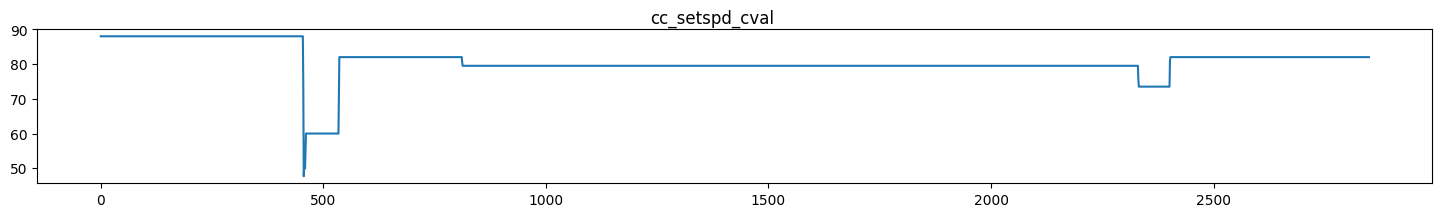

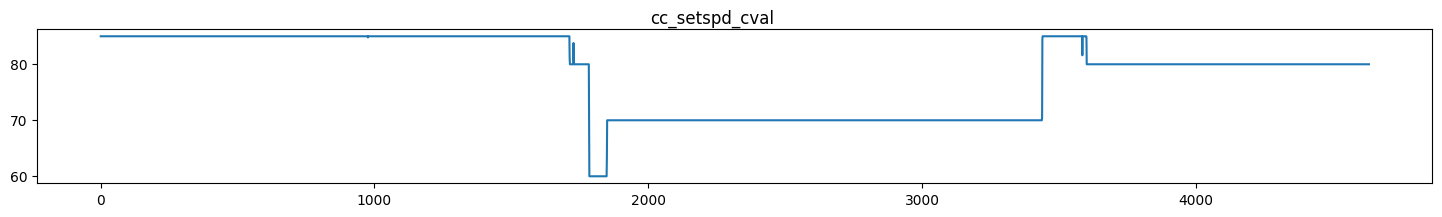

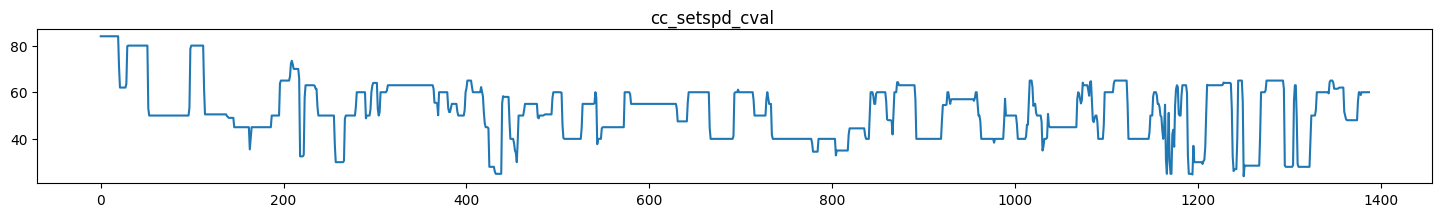

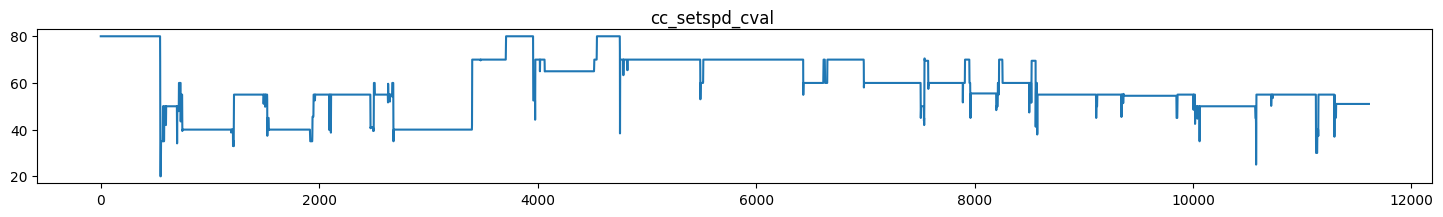

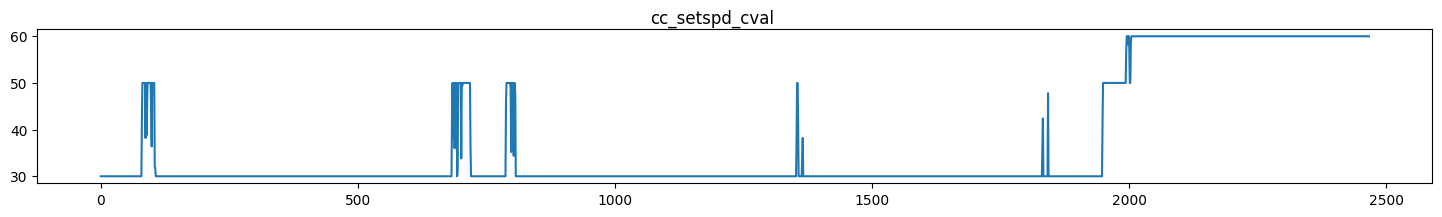

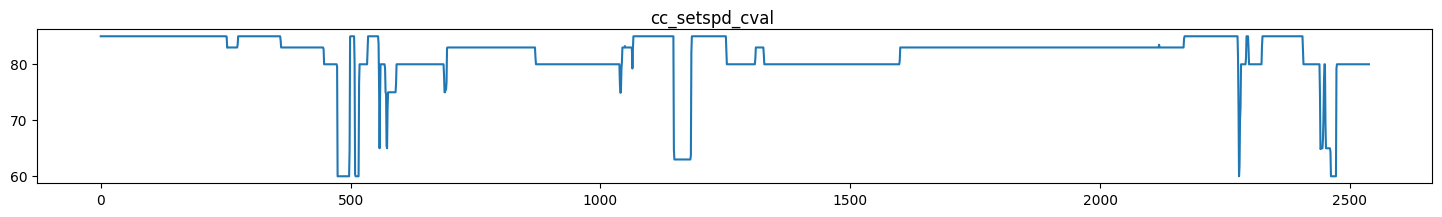

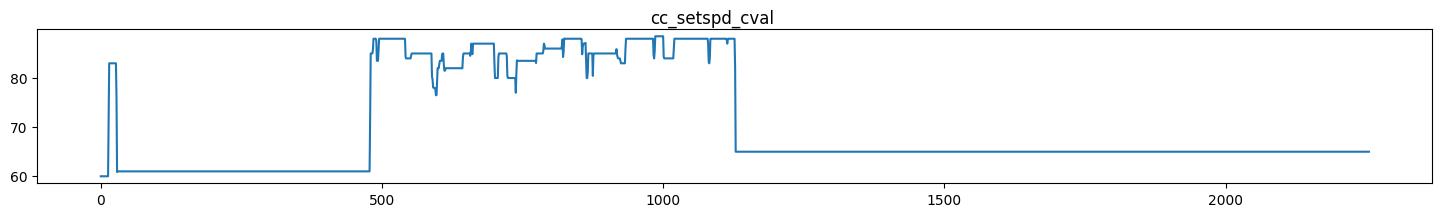

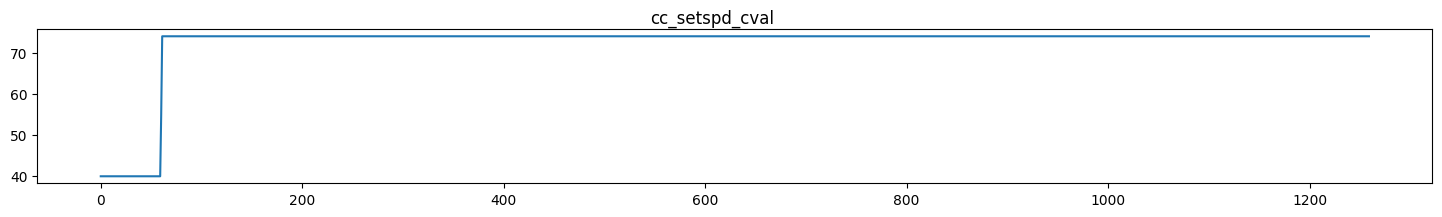

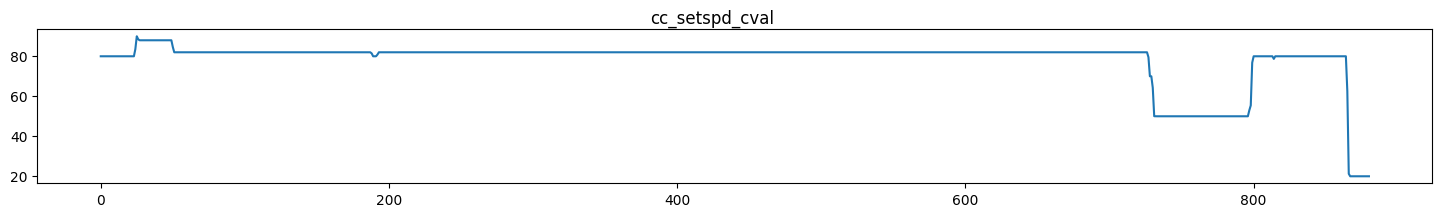

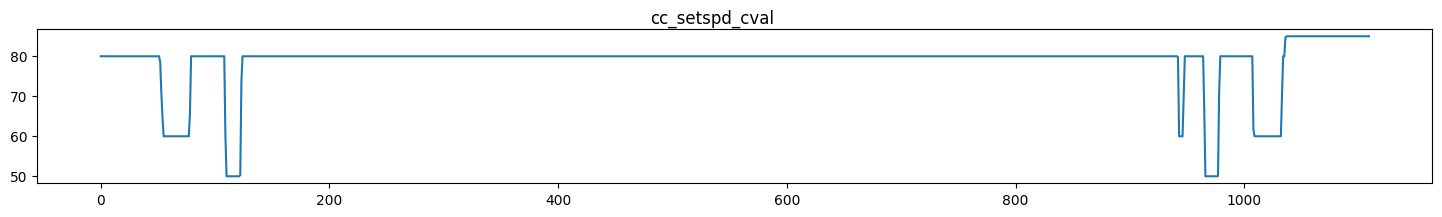

In [156]:
import matplotlib.pyplot as plt
import random

samples = random.sample(trips, 10)
signal  = random.choice(columns)

for f in samples:
    df = pd.read_parquet(Path(trips_processed_resampled, f), engine='fastparquet')
    _ = df[signal].plot(figsize=(18, 2), subplots=True, title=signal)
    plt.show()



In [138]:
df['hv_bat_soh_cval_bms1'].isna().all()

True

In [12]:
def check_nans_in_parquet_files(directories):
    files_with_nans = []

    for directory in directories:
        for file in directory.glob("*.parquet"):
            df = pd.read_parquet(file, engine='fastparquet')
            if df.isna().any().any():
                nan_columns = df.columns[df.isna().any()].tolist()
                files_with_nans.append((file, nan_columns))
                print(f"File {file} has NaNs in columns: {nan_columns}")

    return files_with_nans

directories = [trips_processed_resampled, trips_processed_final]
files_with_nans = check_nans_in_parquet_files(directories)

print("Files with NaNs:")
for file in files_with_nans:
    print(file)

Files with NaNs:


In [13]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2421 entries, 0 to 2420
Data columns (total 82 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   accelpdlposn_cval              2421 non-null   float64       
 1   actdrvtrnpwrprc_cval           2421 non-null   float64       
 2   actualdcvoltage_pti1           2421 non-null   float64       
 3   actualdcvoltage_pti2           2421 non-null   float64       
 4   actualspeed_pti1               2421 non-null   float64       
 5   actualspeed_pti2               2421 non-null   float64       
 6   actualtorque_pti1              2421 non-null   float64       
 7   actualtorque_pti2              2421 non-null   float64       
 8   airtempinsd_cval_hvac          2421 non-null   float64       
 9   airtempinsd_rq                 2421 non-null   float64       
 10  airtempoutsd_cval_cpc          2421 non-null   float64       
 11  airtempoutsd_cval

In [55]:
%%skip
def get_non_empty_columns(parquet_folder):
    # Initialize a set with all column names from the first file
    first_file = next(parquet_folder.glob("*.parquet"))
    df = pd.read_parquet(first_file, engine='fastparquet')
    non_empty_columns = set(df.columns)

    # Iterate through each file and update the set of non-empty columns
    for file in parquet_folder.glob("*.parquet"):
        df = pd.read_parquet(file, engine='fastparquet')
        non_empty_columns &= set(df.columns[df.notna().any()])

    return list(non_empty_columns)

non_empty_columns = get_non_empty_columns(parquet_folder)
print("Columns that are never empty in any file:")


Columns that are never empty in any file:
['motortemperature_pti1', 'hirestotalvehdist_cval_cpc', 'latitude_cval_ippc', 'motortemperature_pti2', 'hirestotalvehdist_cval_icuc', 'hv_batavcelltemp_cval_bms1', 'hv_bat_soc_cval_bms1', 'hv_batmomavldischrgen_cval_1', 'actualspeed_pti2', 'actualspeed_pti1', 'signal_time', 'hv_bat_dc_minvoltlim_cval', 'grshift_stat_pt', 'accelpdlposn_cval', 'powerstagetemperature_pti2', 'airtempinsd_rq', 'vehweight_cval_pt', 'airtempinsd_cval_hvac', 'bs_brk_cval', 'signal_ts', 'txoiltemp_cval_tcm', 'actualdcvoltage_pti2', 'selgr_rq_pt', 'ignsw_stat_sca', 'hv_batmomavlchrgen_cval_bms1', 'rmsmotorcurrent_pti1', 'ambtemp_cval_pt', 'altitude_cval_ippc', 'plugchrg_stat', 'currgr_stat_edcu', 'rmsmotorcurrent_pti2', 'hv_bat_dc_maxvoltlim_cval', 'hv_chrgpwr_ecpc_cval', 'hv_bat_soh_cval_bms1', 'hv_batcurr_cval_bms1', 'hv_batlowcelltemp_cval_bms1', 'edrvspd_cval', 'hv_bathighcelltemp_cval_bms1', 'airtempoutsd_cval_sca', 'cc_actv_stat', 'roadgrad_cval_pt', 'hv_batmaxdisc

In [89]:
# empty_columns = [col for col in all_columns if col not in non_empty_columns and col not in sparse_signals]
empty_columns = ['cc_setspd_cval', 'minmoduletempindex_bms01', 'brc_stat_brc2', 'maxbrickvoltage_bms01', 'maxpwr_contendrnbrkresist2', 
'chargestate', 'actualtorque_pti2', 'dsrdpwr_contendrn2_cval', 'maproadgrad_cval', 'hv_batisores_cval_e2e', 'emot_pwr_cval', 'dsrdpwr_contendrn_cval', 
'grocmbvehweight_cval', 'actualtorque_pti1', 'brc_stat_brc1', 'pt4_dcb_hvdc_power_max_st3', 'hv_pwr_cval_dcl1', 'airtempoutsd_cval_cpc', 
'actdrvtrnpwrprc_cval', 'meanmoduletemperature_bms01', 'linkvoltage_bms05', 'hv_ptc_cabin1_pwr_cval', 'lv_conv_voltdmd_e2e_dcl1', 
'lv_convmaxcurr_cval_dcl1', 'hv_batlinkvoltage_sc01', 'hv_dclink_volt_cval_brc2', 'maxmoduletempindex_bms01', 'elcomp_pwrcons_cval', 
'lv_convcurr_cval_dcl1', 'oiltemp_ra_cval', 'pt4_dcb_temp1_st3', 'pt4_dcb_temp2_st3', 'hv_curr_cval_dcl1', 'hv_dclink_volt_cval_dcl1', 
'lv_conv_dc_momvolt_cval_dcl1', 'maxrecuppwrprc_cval', 'hv_ptc2_pwr_cval', 'currpwr_contendrnbrkresist2', 'lv_convpwr_cval_dcl1', 
'epto_pwr_cval', 'maxtracpwrpct_cval', 'currtmp_brkresist1int_cval', 'hv_dclink_volt_cval_brc', 'currpwr_contendrnbrkresist_cval', 
'maxpwr_contendrnbrkresist_cval', 'hv_bat_intres_cval_bms1', 'stringvoltage_bms01', 'currtmp_brkresist2int_cval', 'hv_bat_dc_volt_cval_bms1']


In [71]:
%%skip
def find_files_with_all_nans(parquet_folder, empty_columns):
    result = {column: {"count": 0, "files": []} for column in empty_columns}
    
    for file in parquet_folder.glob("*.parquet"):
        print(file)
        df = pd.read_parquet(file, engine='fastparquet', columns=empty_columns)
        
        for column in empty_columns:
            if df[column].isna().all():
                result[column]["count"] += 1
                result[column]["files"].append(file.name)
    
    return result

nan_columns_files = find_files_with_all_nans(parquet_folder, empty_columns)

for column, info in nan_columns_files.items():
    print(f"Column: {column}")
    print(f"Number of files with all NaNs: {info['count']}")
    print(f"Files: {info['files']}\n")


C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\processed\v_id983V101_trip1.parquet
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\processed\v_id983V101_trip10.parquet
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\processed\v_id983V101_trip100.parquet
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\processed\v_id983V101_trip101.parquet
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\processed\v_id983V101_trip103.parquet
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\processed\v_id983V101_trip104.parquet
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\processed\v_id983V101_trip104_2.parquet
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\processed\v_id983V101_trip105.parquet
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\processed\v_id983V101_trip105_2.parquet
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\processed\v_id983V101_trip107.parquet
C:\Users\SIEGLEW\OneDrive - Daimler Tru

In [96]:
%%skip
collected_files = set()
collected_signals = []

for column, info in nan_columns_files.items():
    if info['count'] < 140:
        for file_name in info['files']:
            collected_files.add(file_name)
    else:
        collected_signals.append(column)

collected_files =[x for x in collected_files if x not in short_trips]
print(f"Collected parquet files: {len(collected_files)}")
for file in collected_files:
    print(file)

print(f"Collected signals: {len(collected_signals)}")
for signal in collected_signals:
    print(signal)

Collected parquet files: 176
v_id983V2_trip5.parquet
v_id983V10_trip60.parquet
v_id983V2_trip19.parquet
v_id983V13_trip2.parquet
v_id983V13_trip276_2.parquet
v_id983V14_trip2.parquet
v_id983V16_trip185.parquet
v_id983V11_trip15.parquet
v_id983V10_trip27.parquet
v_id983V10_trip48.parquet
v_id983V1_trip8.parquet
v_id983V10_trip21.parquet
v_id983V16_trip304.parquet
v_id983V2_trip37.parquet
v_id983V1_trip16.parquet
v_id983V1_trip16_2.parquet
v_id983V10_trip57.parquet
v_id983V16_trip190.parquet
v_id983V10_trip29_2.parquet
v_id983V16_trip197_2.parquet
v_id983V10_trip39.parquet
v_id983V10_trip49.parquet
v_id983V101_trip54.parquet
v_id983V1_trip2_2.parquet
v_id983V10_trip4.parquet
v_id983V17_trip46.parquet
v_id983V101_trip175.parquet
v_id983V10_trip39_2.parquet
v_id983V11_trip16.parquet
v_id983V2_trip44.parquet
v_id983V10_trip61.parquet
v_id983V10_trip54.parquet
v_id983V16_trip188_2.parquet
v_id983V10_trip35.parquet
v_id983V10_trip16.parquet
v_id983V17_trip69.parquet
v_id983V17_trip1.parquet
v

In [99]:
# Results:
remove_selection = ['v_id983V2_trip5.parquet', 'v_id983V10_trip60.parquet', 'v_id983V2_trip19.parquet', 'v_id983V13_trip2.parquet', 
'v_id983V13_trip276_2.parquet', 'v_id983V14_trip2.parquet', 'v_id983V16_trip185.parquet', 'v_id983V11_trip15.parquet', 
'v_id983V10_trip27.parquet', 'v_id983V10_trip48.parquet', 'v_id983V1_trip8.parquet', 'v_id983V10_trip21.parquet', 'v_id983V16_trip304.parquet', 
'v_id983V2_trip37.parquet', 'v_id983V1_trip16.parquet', 'v_id983V1_trip16_2.parquet', 'v_id983V10_trip57.parquet', 'v_id983V16_trip190.parquet',
'v_id983V10_trip29_2.parquet', 'v_id983V16_trip197_2.parquet', 'v_id983V10_trip39.parquet', 'v_id983V10_trip49.parquet', 'v_id983V101_trip54.parquet', 
'v_id983V1_trip2_2.parquet', 'v_id983V10_trip4.parquet', 'v_id983V17_trip46.parquet', 'v_id983V101_trip175.parquet', 'v_id983V10_trip39_2.parquet',
'v_id983V11_trip16.parquet', 'v_id983V2_trip44.parquet', 'v_id983V10_trip61.parquet', 'v_id983V10_trip54.parquet', 'v_id983V16_trip188_2.parquet',
'v_id983V10_trip35.parquet', 'v_id983V10_trip16.parquet', 'v_id983V17_trip69.parquet', 'v_id983V17_trip1.parquet', 'v_id983V10_trip38.parquet', 
'v_id983V1_trip1.parquet', 'v_id983V10_trip52_2.parquet', 'v_id983V1_trip7.parquet', 'v_id983V10_trip23.parquet', 'v_id983V11_trip16_2.parquet',
'v_id983V16_trip184.parquet', 'v_id983V2_trip21.parquet', 'v_id983V2_trip15.parquet', 'v_id983V10_trip47.parquet', 'v_id983V2_trip12.parquet', 
'v_id983V2_trip3_2.parquet', 'v_id983V16_trip180.parquet', 'v_id983V2_trip25.parquet', 'v_id983V2_trip7.parquet', 'v_id983V16_trip179.parquet',
'v_id983V2_trip27.parquet', 'v_id983V2_trip13.parquet', 'v_id983V2_trip3.parquet', 'v_id983V17_trip70.parquet', 'v_id983V11_trip13_2.parquet',
'v_id983V1_trip9_2.parquet', 'v_id983V10_trip26_2.parquet', 'v_id983V10_trip24.parquet', 'v_id983V10_trip29.parquet', 'v_id983V2_trip17.parquet',
'v_id983V10_trip55.parquet', 'v_id983V10_trip14.parquet', 'v_id983V16_trip178.parquet', 'v_id983V10_trip58.parquet', 'v_id983V2_trip39.parquet',
'v_id983V16_trip183.parquet', 'v_id983V10_trip37.parquet', 'v_id983V10_trip5.parquet', 'v_id983V10_trip20_2.parquet', 'v_id983V2_trip32.parquet',
'v_id983V16_trip188.parquet', 'v_id983V2_trip36.parquet', 'v_id983V10_trip25.parquet', 'v_id983V2_trip30.parquet', 'v_id983V11_trip14_2.parquet',
'v_id983V2_trip20.parquet', 'v_id983V2_trip38.parquet', 'v_id983V16_trip184_2.parquet', 'v_id983V1_trip11.parquet', 'v_id983V10_trip55_2.parquet',
'v_id983V10_trip5_2.parquet', 'v_id983V10_trip37_2.parquet', 'v_id983V2_trip39_2.parquet', 'v_id983V10_trip3.parquet',
'v_id983V10_trip60_2.parquet', 'v_id983V10_trip2.parquet', 'v_id983V2_trip16.parquet', 'v_id983V2_trip24.parquet', 'v_id983V2_trip18.parquet', 
'v_id983V10_trip59.parquet', 'v_id983V16_trip182.parquet', 'v_id983V1_trip6_2.parquet', 'v_id983V10_trip42.parquet', 'v_id983V2_trip44_2.parquet',
'v_id983V10_trip18.parquet', 'v_id983V17_trip2.parquet', 'v_id983V16_trip3.parquet', 'v_id983V2_trip36_2.parquet', 'v_id983V10_trip10.parquet', 
'v_id983V16_trip192.parquet', 'v_id983V2_trip35.parquet', 'v_id983V13_trip5.parquet', 'v_id983V2_trip10.parquet', 'v_id983V1_trip9.parquet', 
'v_id983V10_trip6.parquet', 'v_id983V10_trip44.parquet', 'v_id983V19_trip2_2.parquet', 'v_id983V16_trip186.parquet', 'v_id983V10_trip15.parquet',
'v_id983V19_trip4.parquet', 'v_id983V11_trip13.parquet', 'v_id983V16_trip196.parquet', 'v_id983V2_trip33.parquet', 'v_id983V16_trip191.parquet',
'v_id983V1_trip2.parquet', 'v_id983V10_trip41.parquet', 'v_id983V16_trip193.parquet', 'v_id983V2_trip11.parquet', 'v_id983V17_trip5.parquet',
'v_id983V10_trip17.parquet', 'v_id983V1_trip15.parquet', 'v_id983V10_trip9.parquet', 'v_id983V2_trip4.parquet', 'v_id983V10_trip42_2.parquet',
'v_id983V10_trip52.parquet', 'v_id983V4_trip86.parquet', 'v_id983V10_trip40.parquet', 'v_id983V10_trip28.parquet',
'v_id983V10_trip14_2.parquet', 'v_id983V2_trip23.parquet', 'v_id983V16_trip181.parquet', 'v_id983V1_trip4.parquet', 
'v_id983V10_trip7.parquet', 'v_id983V1_trip34.parquet', 'v_id983V19_trip1.parquet', 'v_id983V2_trip34.parquet', 'v_id983V10_trip43.parquet',
'v_id983V16_trip187.parquet', 'v_id983V17_trip4.parquet', 'v_id983V13_trip276.parquet', 'v_id983V10_trip26.parquet', 
'v_id983V16_trip180_2.parquet', 'v_id983V16_trip195.parquet', 'v_id983V11_trip14.parquet', 'v_id983V16_trip197.parquet',
'v_id983V13_trip1.parquet', 'v_id983V1_trip12.parquet', 'v_id983V10_trip56.parquet', 'v_id983V10_trip59_2.parquet',
'v_id983V2_trip8.parquet', 'v_id983V2_trip1.parquet', 'v_id983V2_trip22_2.parquet', 'v_id983V1_trip10.parquet', 'v_id983V2_trip42.parquet', 
'v_id983V2_trip15_2.parquet', 'v_id983V10_trip57_2.parquet', 'v_id983V10_trip49_2.parquet', 'v_id983V10_trip8.parquet',
'v_id983V10_trip50.parquet', 'v_id983V4_trip79.parquet', 'v_id983V16_trip194.parquet', 'v_id983V2_trip2.parquet',
'v_id983V10_trip13_2.parquet', 'v_id983V13_trip4.parquet', 'v_id983V17_trip6.parquet', 'v_id983V2_trip24_2.parquet', 
'v_id983V2_trip9.parquet', 'v_id983V16_trip185_2.parquet', 'v_id983V10_trip13.parquet', 'v_id983V2_trip14.parquet', 
'v_id983V2_trip22.parquet', 'v_id983V19_trip2.parquet', 'v_id983V2_trip6.parquet']

collected_signals = ['brc_stat_brc2', 'maxpwr_contendrnbrkresist2', 'dsrdpwr_contendrn2_cval', 'maproadgrad_cval',
'dsrdpwr_contendrn_cval', 'brc_stat_brc1', 'meanmoduletemperature_bms01', 'linkvoltage_bms05', 'hv_dclink_volt_cval_brc2',
'oiltemp_ra_cval', 'hv_ptc2_pwr_cval', 'currpwr_contendrnbrkresist2', 'epto_pwr_cval', 'currtmp_brkresist1int_cval', 
'hv_dclink_volt_cval_brc', 'currpwr_contendrnbrkresist_cval', 'maxpwr_contendrnbrkresist_cval', 'currtmp_brkresist2int_cval', 'hv_bat_dc_volt_cval_bms1']
len(remove_selection), len(collected_signals)

(176, 19)

In [20]:
def check_all_nan_columns(parquet_folder, remove_selection):
    files_with_all_nan_columns = []

    for file_name in remove_selection:
        file_path = Path(parquet_folder, file_name)
        df = pd.read_parquet(file_path, engine='fastparquet')
        columns_to_check = [col for col in df.columns if col not in drop_signals]
        all_nan_columns = df[columns_to_check].columns[df[columns_to_check].isna().all()].tolist()
        
        if all_nan_columns:
            files_with_all_nan_columns.append((file_name, all_nan_columns))
            print(f"File {file_name} has all-NaN columns: {all_nan_columns}")

    return files_with_all_nan_columns

files_with_all_nan_columns = check_all_nan_columns(parquet_folder, trips)

In [60]:
def find_files_with_all_nans(parquet_folder, empty_columns):
    result = {column: {"count": 0, "files": []} for column in empty_columns}
    
    for file in parquet_folder.glob("*.parquet"):
        df = pd.read_parquet(file, engine='fastparquet', columns=empty_columns)
        
        for column in empty_columns:
            if df[column].notna().any():
                result[column]["count"] += 1
                result[column]["files"].append(file.name)
    
    return result

nan_columns_files = find_files_with_all_nans(parquet_folder, ["epto_pwr_cval"])

for column, info in nan_columns_files.items():
    print(f"Column: {column}")
    print(f"Number of files with any NaNs: {info['count']}")
    print(f"Files: {info['files']}\n")

Column: epto_pwr_cval
Number of files with any NaNs: 1047
Files: ['v_id983V19_trip43.parquet', 'v_id983V18_trip248.parquet', 'v_id983V19_trip92.parquet', 'v_id983V12_trip63.parquet', 'v_id983V18_trip200_2.parquet', 'v_id983V19_trip139.parquet', 'v_id983V12_trip138_2.parquet', 'v_id983V18_trip27.parquet', 'v_id983V16_trip174.parquet', 'v_id983V18_trip102_2.parquet', 'v_id983V18_trip30.parquet', 'v_id983V16_trip266_2.parquet', 'v_id983V18_trip172.parquet', 'v_id983V19_trip31.parquet', 'v_id983V16_trip188.parquet', 'v_id983V18_trip42.parquet', 'v_id983V16_trip236.parquet', 'v_id983V16_trip184.parquet', 'v_id983V16_trip305.parquet', 'v_id983V19_trip116.parquet', 'v_id983V16_trip264.parquet', 'v_id983V12_trip168_2.parquet', 'v_id983V18_trip246_2.parquet', 'v_id983V16_trip24.parquet', 'v_id983V19_trip32_2.parquet', 'v_id983V16_trip105.parquet', 'v_id983V12_trip149.parquet', 'v_id983V12_trip209_2.parquet', 'v_id983V18_trip238.parquet', 'v_id983V12_trip79_2.parquet', 'v_id983V12_trip96.parquet

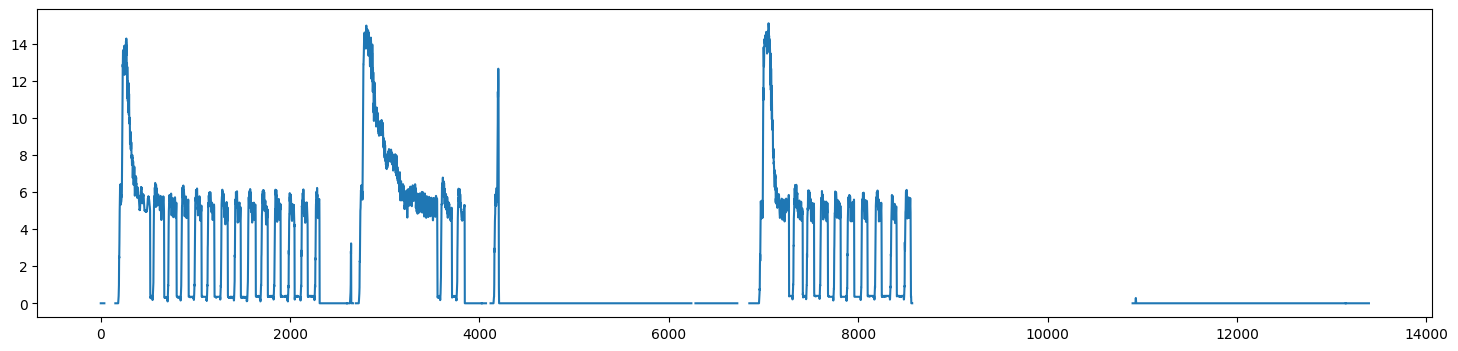

In [94]:
sample = random.choice(info['files'])
df = pd.read_parquet(Path(DATA_PATH, "processed", sample), engine='fastparquet')
#_ = df['actdrvtrnpwrprc_cval'].plot(figsize=(18, 4), subplots=True, color='r')
_ = df['epto_pwr_cval'].plot(figsize=(18, 4), subplots=True)

In [217]:
collected_files = set()
collected_signals = []

for column, info in nan_columns_files.items():
    if info['count'] < 5:
        for file_name in info['files']:
            collected_files.add(file_name)
    else:
        collected_signals.append(column)

collected_files =[x for x in collected_files if x not in short_trips]
print(f"Collected parquet files: {len(collected_files)}")
for file in collected_files:
    print(file)

print(f"Collected signals: {len(collected_signals)}")
for signal in collected_signals:
    print(signal)

Collected parquet files: 0
Collected signals: 0


NameError: name 'df' is not defined